In [1]:
import cv2
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd, numpy as np
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19,ResNet50
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
import time


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DEVICE = "TPU" #or "GPU"

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.MirroredStrategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  2
REPLICAS: 2


In [3]:
data_dir = Path('../input/chest-xray-pneumonia/chest_xray/chest_xray')

train_dir = data_dir / 'train'
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_data = []

for img in normal_cases:
    train_data.append((img,0))

for img in pneumonia_cases:
    train_data.append((img, 1))

train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

train_data = train_data.sample(frac=1.).reset_index(drop=True)

In [4]:
val_dir = data_dir / 'val'
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

val_data = []

for img in normal_cases:
    val_data.append((img,0))

for img in pneumonia_cases:
    val_data.append((img, 1))

val_data = pd.DataFrame(val_data, columns=['image', 'label'],index=None)

val_data = val_data.sample(frac=1.).reset_index(drop=True)

In [5]:
test_dir = data_dir / 'test'
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []

for img in normal_cases:
    test_data.append((img,0))

for img in pneumonia_cases:
    test_data.append((img, 1))

test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

test_data = test_data.sample(frac=1.).reset_index(drop=True)

In [6]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=True,
    brightness_range = (0.9,1.1),
    shear_range=0.1,
    zoom_range=0.1,
#     samplewise_center=True,
    rescale=1.0/255.0
)

image_generator2 = ImageDataGenerator(
    rescale=1.0/255.0
)

In [7]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=16, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))
validation = image_generator2.flow_from_directory(test_dir, 
                                            batch_size=16, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
len(train)

326

In [9]:
len(validation)

39

In [10]:
dim = 180
base = ResNet50(input_shape=(dim,dim,3),weights='imagenet',include_top=False)
base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
dim = 180
inp = tf.keras.layers.Input(shape=(dim,dim,3))
base = ResNet50(input_shape=(dim,dim,3),weights='imagenet',include_top=False)
count = 0
for i in base.layers:
    if "conv4" in i.name:
        break
    count+=1
a = [i.name for i in base.layers][count:]
base.trainable = True
set_trainable = False
for layer in base.layers:
  if layer.name in a:
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
x = base(inp)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
#base.trainable = False

model = tf.keras.Model(inputs=inp,outputs=x)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
model.compile(optimizer=opt,loss=loss,metrics=['accuracy',tf.keras.metrics.AUC(name='auc'),tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')])
model.summary()

In [17]:
def resnet_model(dim=128):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = ResNet50(input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    count = 0
    for i in base.layers:
        if "conv4_block6_3" in i.name:
            break
        count+=1
    a = [i.name for i in base.layers][count:]
    base.trainable = True
    set_trainable = False
    for layer in base.layers:
      if layer.name in a:
        set_trainable = True
      if set_trainable:
        layer.trainable = True
      else:
        layer.trainable = False
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=loss,metrics=['accuracy',tf.keras.metrics.AUC(name='auc'),tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
    return model

In [23]:
!pip install -q efficientnet >> /dev/null
import efficientnet.tfkeras as efn

In [25]:
dim = 180
base = efn.EfficientNetB6(input_shape=(dim,dim,3),weights='imagenet',include_top=False)
base.summary()

165527152/165527152 [==============================] - 1s 0us/step
Model: "efficientnet-b6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 90, 90, 56)   1512        ['input_3[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 90, 90, 56)   224         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation 

In [33]:
def eff_model(dim=128):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = efn.EfficientNetB6(input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    count = 0
    for i in base.layers:
        if "block6d" in i.name:
            break
        count+=1
    a = [i.name for i in base.layers][count:]
    base.trainable = True
    set_trainable = False
    for layer in base.layers:
      if layer.name in a:
        set_trainable = True
      if set_trainable:
        layer.trainable = True
      else:
        layer.trainable = False
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=loss,metrics=['accuracy',tf.keras.metrics.AUC(name='auc'),tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
    return model

In [38]:
dim = 180
base = VGG19(input_shape=(dim,dim,3),weights='imagenet',include_top=False)
base.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

In [40]:
def vgg_model(dim=128):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    base = VGG19(input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    count = 0
    for i in base.layers:
        if "block4" in i.name:
            break
        count+=1
    a = [i.name for i in base.layers][count:]
    base.trainable = True
    set_trainable = False
    for layer in base.layers:
      if layer.name in a:
        set_trainable = True
      if set_trainable:
        layer.trainable = True
      else:
        layer.trainable = False
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=loss,metrics=['accuracy',tf.keras.metrics.AUC(name='auc'),tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
    return model

In [34]:
dim = 224
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(dim, dim, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

#     model = Model(inputs=inp, outputs=out)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
model.compile(optimizer=opt,loss=loss,metrics=['accuracy',tf.keras.metrics.AUC(name='auc'),tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 93312)             0         
                                                                 
 dense_6 (Dense)             (None, 32)               

In [35]:
from tensorflow.keras.layers import Dropout, BatchNormalization

# Modified CNN model with increased complexity and regularization
def cnn_model(dim=128):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(dim, dim, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

#     model = Model(inputs=inp, outputs=out)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=loss,metrics=['accuracy',tf.keras.metrics.AUC(name='auc'),tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])
    return model

In [19]:
from tensorflow.keras.callbacks import LearningRateScheduler

def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [19]:
loss = []
batch_size = 1
K.clear_session()
with strategy.scope():
    model = resnet_model(dim=224)

# TRAIN
print('Training...')
start_time = time.time()

history = model.fit(train, 
    epochs=10, 
    steps_per_epoch=len(train)//batch_size,
    batch_size= batch_size,
    validation_data=validation,
    callbacks=[get_lr_callback(batch_size)],
    validation_steps = len(validation)//batch_size
)

end_time = time.time()
print("Training Time: ",end_time-start_time)

# PREDICT OOF USING TTA
print('Predicting OOF with TTA...')
evaluation =model.evaluate(validation)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")                

loss.append(history.history["loss"])

# PLOT TRAINING
plt.figure(figsize=(15,5))

plt.plot(np.arange(10),history.history['accuracy'],'-o',label='Train accuracy',color='#808080')
plt.plot(np.arange(10),history.history['val_accuracy'],'-o',label='Val accuracy',color='#000000')
x = np.argmin( history.history['val_accuracy'] ); y = np.min( history.history['val_accuracy'] )
xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#000000'); plt.text(x-0.03*xdist,y+0.05*ydist,'min accuracy',size=14)
plt.ylabel('accuracy',size=14)
plt.legend(loc=5)

plt2 = plt.gca().twinx()
plt2.plot(np.arange(10),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
plt2.plot(np.arange(10),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
plt.ylabel('Loss',size=14)
plt.legend(loc=3)
plt.show()

Training...
Epoch 1/10
326/326 [==============================] - 144s 368ms/step - loss: 0.3842 - accuracy: 0.8466 - auc: 0.9044 - precision: 0.8727 - recall: 0.9290 - val_loss: 0.8415 - val_accuracy: 0.6266 - val_auc: 0.9451 - val_precision: 0.6260 - val_recall: 1.0000 - lr: 5.0000e-06
Epoch 2/10
326/326 [==============================] - 115s 351ms/step - loss: 0.3104 - accuracy: 0.8992 - auc: 0.9516 - precision: 0.9245 - recall: 0.9412 - val_loss: 0.3327 - val_accuracy: 0.8878 - val_auc: 0.9542 - val_precision: 0.8791 - val_recall: 0.9513 - lr: 4.5000e-06
Epoch 3/10
326/326 [==============================] - 115s 353ms/step - loss: 0.2912 - accuracy: 0.9099 - auc: 0.9615 - precision: 0.9322 - recall: 0.9476 - val_loss: 0.6388 - val_accuracy: 0.7452 - val_auc: 0.9520 - val_precision: 0.7119 - val_recall: 0.9949 - lr: 4.0000e-06
Epoch 4/10
326/326 [==============================] - 114s 350ms/step - loss: 0.2876 - accuracy: 0.9061 - auc: 0.9624 - precision: 0.9328 - recall: 0.9414 - 

NameError: name 'test' is not defined

39/39 [==============================] - 7s 156ms/step - loss: 0.3776 - accuracy: 0.8686 - auc: 0.9615 - precision: 0.8319 - recall: 0.9897
Test Accuracy: 86.86%
326/326 [==============================] - 104s 318ms/step - loss: 0.2187 - accuracy: 0.9530 - auc: 0.9880 - precision: 0.9666 - recall: 0.9703
Train Accuracy: 95.30%


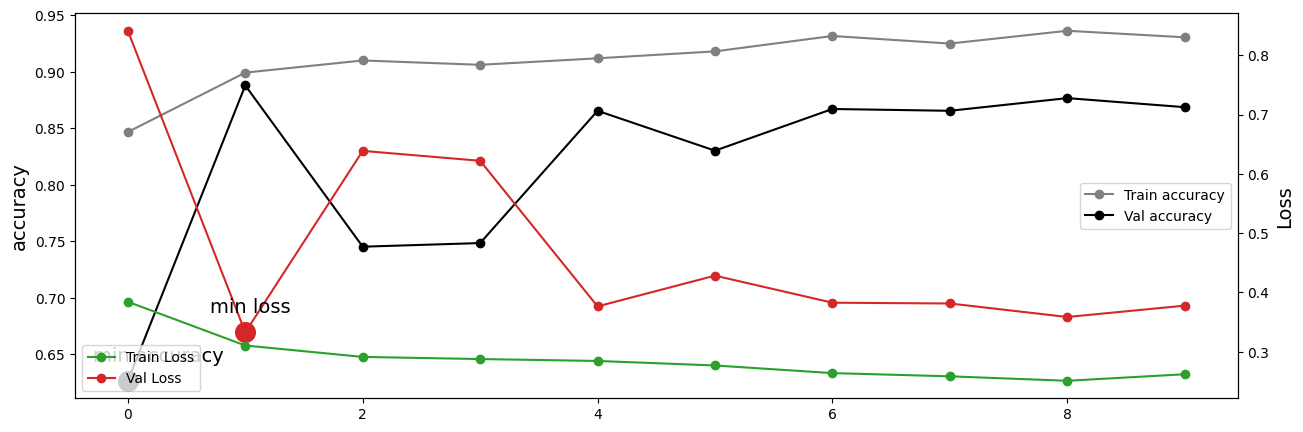

In [20]:
evaluation =model.evaluate(validation)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")                

loss.append(history.history["loss"])

# PLOT TRAINING
plt.figure(figsize=(15,5))

plt.plot(np.arange(10),history.history['accuracy'],'-o',label='Train accuracy',color='#808080')
plt.plot(np.arange(10),history.history['val_accuracy'],'-o',label='Val accuracy',color='#000000')
x = np.argmin( history.history['val_accuracy'] ); y = np.min( history.history['val_accuracy'] )
xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#000000'); plt.text(x-0.03*xdist,y+0.05*ydist,'min accuracy',size=14)
plt.ylabel('accuracy',size=14)
plt.legend(loc=5)

plt2 = plt.gca().twinx()
plt2.plot(np.arange(10),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
plt2.plot(np.arange(10),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
plt.ylabel('Loss',size=14)
plt.legend(loc=3)
plt.show()

Training...
Epoch 1/10


2023-10-11 19:22:31.080029: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnet-b6/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


326/326 [==============================] - 226s 427ms/step - loss: 0.6411 - accuracy: 0.6398 - auc: 0.7507 - precision: 0.8716 - recall: 0.6041 - val_loss: 0.6165 - val_accuracy: 0.7147 - val_auc: 0.8426 - val_precision: 0.8376 - val_recall: 0.6744 - lr: 5.0000e-06
Epoch 2/10
326/326 [==============================] - 144s 441ms/step - loss: 0.4959 - accuracy: 0.8393 - auc: 0.9071 - precision: 0.9300 - recall: 0.8475 - val_loss: 0.5240 - val_accuracy: 0.7901 - val_auc: 0.8774 - val_precision: 0.8381 - val_recall: 0.8231 - lr: 4.5000e-06
Epoch 3/10
326/326 [==============================] - 129s 397ms/step - loss: 0.4101 - accuracy: 0.8771 - auc: 0.9307 - precision: 0.9404 - recall: 0.8911 - val_loss: 0.4592 - val_accuracy: 0.8109 - val_auc: 0.9018 - val_precision: 0.8505 - val_recall: 0.8462 - lr: 4.0000e-06
Epoch 4/10
326/326 [==============================] - 126s 388ms/step - loss: 0.3601 - accuracy: 0.8819 - auc: 0.9440 - precision: 0.9386 - recall: 0.8999 - val_loss: 0.4146 - val_

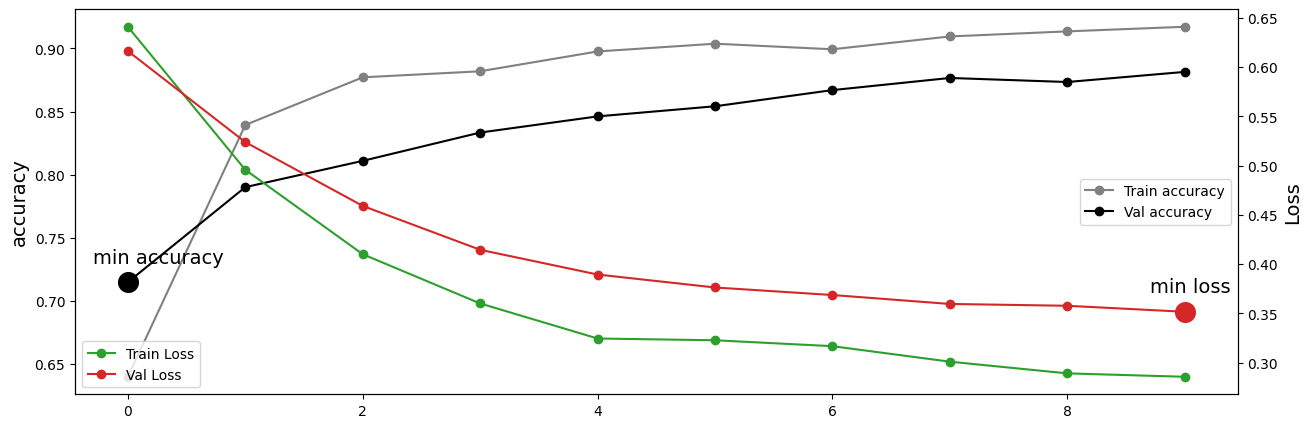

In [35]:
loss = []
batch_size = 1
K.clear_session()
with strategy.scope():
    model = eff_model(dim=224)

# TRAIN
print('Training...')
start_time = time.time()

history = model.fit(train, 
    epochs=10, 
    steps_per_epoch=len(train)//batch_size,
    batch_size= batch_size,
    validation_data=validation,
    callbacks=[get_lr_callback(batch_size)],
    validation_steps = len(validation)//batch_size
)

end_time = time.time()
print("Training Time: ",end_time-start_time)

# PREDICT OOF USING TTA
print('Predicting OOF with TTA...')
evaluation =model.evaluate(validation)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")                

loss.append(history.history["loss"])

# PLOT TRAINING
plt.figure(figsize=(15,5))

plt.plot(np.arange(10),history.history['accuracy'],'-o',label='Train accuracy',color='#808080')
plt.plot(np.arange(10),history.history['val_accuracy'],'-o',label='Val accuracy',color='#000000')
x = np.argmin( history.history['val_accuracy'] ); y = np.min( history.history['val_accuracy'] )
xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#000000'); plt.text(x-0.03*xdist,y+0.05*ydist,'min accuracy',size=14)
plt.ylabel('accuracy',size=14)
plt.legend(loc=5)

plt2 = plt.gca().twinx()
plt2.plot(np.arange(10),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
plt2.plot(np.arange(10),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
plt.ylabel('Loss',size=14)
plt.legend(loc=3)
plt.show()

Training...
Epoch 1/10
326/326 [==============================] - 161s 466ms/step - loss: 0.5992 - accuracy: 0.7368 - auc: 0.4929 - precision: 0.7426 - recall: 0.9881 - val_loss: 0.6665 - val_accuracy: 0.6250 - val_auc: 0.5941 - val_precision: 0.6250 - val_recall: 1.0000 - lr: 5.0000e-06
Epoch 2/10
326/326 [==============================] - 98s 300ms/step - loss: 0.5708 - accuracy: 0.7429 - auc: 0.6118 - precision: 0.7432 - recall: 0.9992 - val_loss: 0.6343 - val_accuracy: 0.6250 - val_auc: 0.7673 - val_precision: 0.6250 - val_recall: 1.0000 - lr: 4.5000e-06
Epoch 3/10
326/326 [==============================] - 98s 301ms/step - loss: 0.5493 - accuracy: 0.7460 - auc: 0.6976 - precision: 0.7459 - recall: 0.9982 - val_loss: 0.6219 - val_accuracy: 0.6250 - val_auc: 0.8054 - val_precision: 0.6250 - val_recall: 1.0000 - lr: 4.0000e-06
Epoch 4/10
326/326 [==============================] - 98s 301ms/step - loss: 0.5265 - accuracy: 0.7517 - auc: 0.7613 - precision: 0.7509 - recall: 0.9964 - val

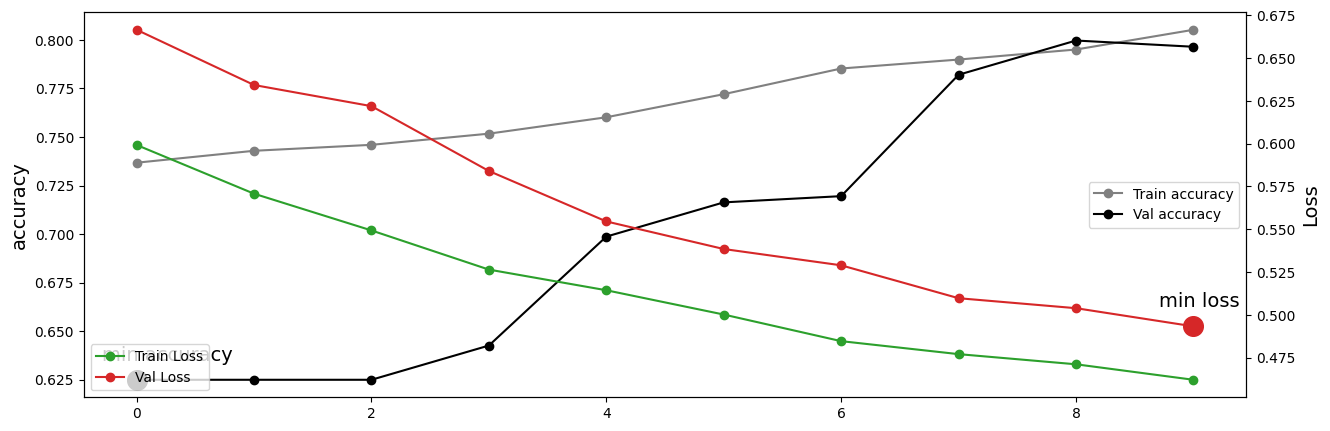

In [37]:
loss = []
batch_size = 1
K.clear_session()
with strategy.scope():
    model = cnn_model(dim=180)

# TRAIN
print('Training...')
start_time = time.time()

history = model.fit(train, 
    epochs=10, 
    steps_per_epoch=len(train)//batch_size,
    batch_size= batch_size,
    validation_data=validation,
    callbacks=[get_lr_callback(batch_size)],
    validation_steps = len(validation)//batch_size
)

end_time = time.time()
print("Training Time: ",end_time-start_time)

# PREDICT OOF USING TTA
print('Predicting OOF with TTA...')
evaluation =model.evaluate(validation)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")                

loss.append(history.history["loss"])

# PLOT TRAINING
plt.figure(figsize=(15,5))

plt.plot(np.arange(10),history.history['accuracy'],'-o',label='Train accuracy',color='#808080')
plt.plot(np.arange(10),history.history['val_accuracy'],'-o',label='Val accuracy',color='#000000')
x = np.argmin( history.history['val_accuracy'] ); y = np.min( history.history['val_accuracy'] )
xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#000000'); plt.text(x-0.03*xdist,y+0.05*ydist,'min accuracy',size=14)
plt.ylabel('accuracy',size=14)
plt.legend(loc=5)

plt2 = plt.gca().twinx()
plt2.plot(np.arange(10),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
plt2.plot(np.arange(10),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
plt.ylabel('Loss',size=14)
plt.legend(loc=3)
plt.show()

Training...
Epoch 1/10
326/326 [==============================] - 128s 363ms/step - loss: 0.3267 - accuracy: 0.8815 - auc: 0.9445 - precision: 0.9050 - recall: 0.9391 - val_loss: 0.2939 - val_accuracy: 0.9231 - val_auc: 0.9664 - val_precision: 0.9191 - val_recall: 0.9615 - lr: 5.0000e-06
Epoch 2/10
326/326 [==============================] - 113s 345ms/step - loss: 0.2180 - accuracy: 0.9536 - auc: 0.9854 - precision: 0.9702 - recall: 0.9672 - val_loss: 0.3622 - val_accuracy: 0.8894 - val_auc: 0.9698 - val_precision: 0.8559 - val_recall: 0.9897 - lr: 4.5000e-06
Epoch 3/10
326/326 [==============================] - 112s 345ms/step - loss: 0.1897 - accuracy: 0.9682 - auc: 0.9923 - precision: 0.9783 - recall: 0.9788 - val_loss: 0.3379 - val_accuracy: 0.8894 - val_auc: 0.9729 - val_precision: 0.8575 - val_recall: 0.9872 - lr: 3.5000e-06
Epoch 5/10
326/326 [==============================] - 113s 347ms/step - loss: 0.1856 - accuracy: 0.9672 - auc: 0.9942 - precision: 0.9778 - recall: 0.9781 - 

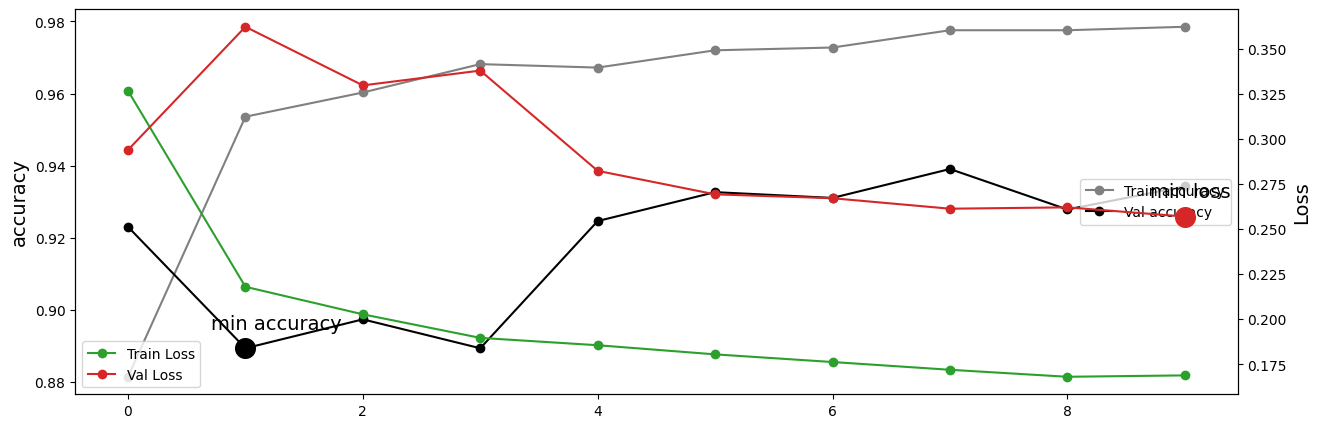

In [41]:
loss = []
batch_size = 1
K.clear_session()
with strategy.scope():
    model = vgg_model(dim=224)

# TRAIN
print('Training...')
start_time = time.time()

history = model.fit(train, 
    epochs=10, 
    steps_per_epoch=len(train)//batch_size,
    batch_size= batch_size,
    validation_data=validation,
    callbacks=[get_lr_callback(batch_size)],
    validation_steps = len(validation)//batch_size
)

end_time = time.time()
print("Training Time: ",end_time-start_time)

# PREDICT OOF USING TTA
print('Predicting OOF with TTA...')
evaluation =model.evaluate(validation)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")                

loss.append(history.history["loss"])

# PLOT TRAINING
plt.figure(figsize=(15,5))

plt.plot(np.arange(10),history.history['accuracy'],'-o',label='Train accuracy',color='#808080')
plt.plot(np.arange(10),history.history['val_accuracy'],'-o',label='Val accuracy',color='#000000')
x = np.argmin( history.history['val_accuracy'] ); y = np.min( history.history['val_accuracy'] )
xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#000000'); plt.text(x-0.03*xdist,y+0.05*ydist,'min accuracy',size=14)
plt.ylabel('accuracy',size=14)
plt.legend(loc=5)

plt2 = plt.gca().twinx()
plt2.plot(np.arange(10),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
plt2.plot(np.arange(10),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
plt.ylabel('Loss',size=14)
plt.legend(loc=3)
plt.show()